## Data / Package Import 

In [1]:
import pandas as pd
import os
from Bio import Affy
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, GRU, Layer, Add, GlobalAveragePooling1D, Conv1D, ReLU
from sklearn.model_selection import KFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dense, Dropout, Activation, LeakyReLU, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_val_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll.base import scope
import scipy.stats as stats
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import backend as K
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from accelerate import DataLoaderConfiguration
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.regularizers import l1
from bayes_opt import BayesianOptimization
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from boruta import BorutaPy
from skrebate import ReliefF
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.svm import SVC

C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\ProgramData\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


## AMGM and Cosine Feature Selection

In [2]:
def calculate_amgm(X):
    """
    Calculate AMGM for each feature (row) in the dataset X.
    
    Parameters:
    X (numpy array): The input data array with shape (n_features, n_samples)
    
    Returns:
    amgm_values (numpy array): The AMGM values for each feature (row)
    """
    N = X.shape[1]
    
    exp_X = np.exp(X)
    amgm_values = (np.mean(exp_X, axis=1)) / (np.exp(np.mean(X, axis=1)))
    
    return amgm_values

In [3]:
def filter_redundant_features(X, relevant_indices, threshold=0.9):
    relevant_features = X[relevant_indices, :]
    cos_sim_matrix = cosine_similarity(relevant_features)
    
    to_keep = []
    to_drop = set()
    for i in range(cos_sim_matrix.shape[0]):
        if i not in to_drop:
            to_keep.append(relevant_indices[i])
            for j in range(i + 1, cos_sim_matrix.shape[0]):
                if cos_sim_matrix[i, j] > threshold:
                    to_drop.add(relevant_indices[j])
    return to_keep

## Autoencoder Feature Selection with Lasso Regression

In [4]:
def create_feature_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)  # Encoder part
    decoded = Dense(input_dim, activation='sigmoid')(encoded)  # Decoder part
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [5]:
def apply_l1_feature_selection(X, y, alpha=0.01, target_features=100):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    model = SelectFromModel(lasso, prefit=True, max_features=target_features)
    X_reduced = model.transform(X)
    selected_indices = model.get_support(indices=True)
    return X_reduced, selected_indices

## Initial Deep Autoencoder

In [6]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    return model

In [7]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [8]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv' #Change for different files

In [9]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_9000\562430524.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [10]:
df.shape

(199225, 143)

In [15]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [16]:
amgm_values = calculate_amgm(X)

In [17]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [18]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [  3208  19630 127297 107306 123971  34247  95571 144356 131398  90903]
Top AMGM values: [1.07140816 1.07144362 1.07145088 1.07148938 1.07150039 1.07150508
 1.07153967 1.07155832 1.07156367 1.07158295]


In [19]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values

In [20]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [21]:
X_selected = X[selected_indices, :].T 

In [38]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [40]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [25]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,826 (50.10 KB)

 Trainable params: 12,826 (50.10 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
def k_fold_cross_validation(X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_dim = X_train.shape[1]
        model = create_deep_autoencoder(input_dim)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        clr = LearningRateScheduler(cyclical_learning_rate)
        history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[clr], verbose=0)

        y_val_pred_prob = model.predict(X_val)
        y_val_pred = (y_val_pred_prob > 0.5).astype(int)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Avg Accuracy: {avg_accuracy}")
    print(f"Avg F1 Score: {avg_f1}")
    print(f"Avg Sensitivity: {avg_sensitivity}")
    print(f"Avg Specificity: {avg_specificity}")

    return avg_accuracy, avg_f1, avg_sensitivity, avg_specificity

In [53]:
avg_accuracy, avg_f1, avg_sensitivity, avg_specificity = k_fold_cross_validation(X_train, y_train, n_splits=5)

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Avg Accuracy: 1.0
Avg F1 Score: 1.0
Avg Sensitivity: 1.0
Avg Specificity: 1.0


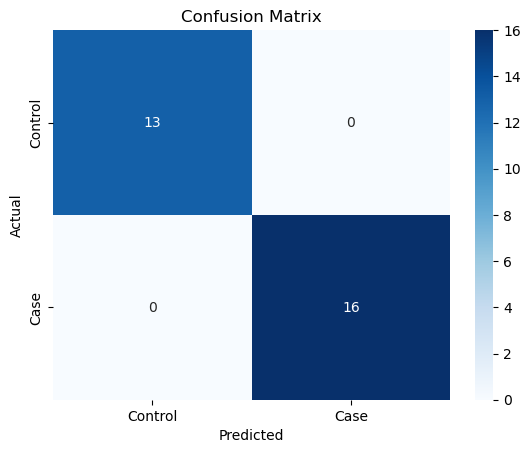

In [54]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Case'], yticklabels=['Control', 'Case'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization)

In [6]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [7]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [8]:
amgm_values = calculate_amgm(X)

In [9]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [10]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [  3208  19630 127297 107306 123971  34247  95571 144356 131398  90903]
Top AMGM values: [1.07140816 1.07144362 1.07145088 1.07148938 1.07150039 1.07150508
 1.07153967 1.07155832 1.07156367 1.07158295]


In [11]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [12]:
X_selected = X[selected_indices, :].T

In [13]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [14]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values  

In [15]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(3, activation='softmax'))  # Final classification layer for multi-class
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [24]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [16]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [17]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [18]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001B986708040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensi

In [19]:
print("Best parameters found: ", best)
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

Best parameters found:  {'batch_size': 16.0, 'dropout_rate': 0.2826648253460785, 'epochs': 100.0, 'learning_rate': 0.0006152054933240435, 'neurons1': 192.0, 'neurons2': 112.0}


In [22]:
def k_fold_cross_validation(X, y, best_params, n_splits=5):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_index, val_index in kfold.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        input_dim = X_train.shape[1]
        model = create_deep_autoencoder(
            input_dim=input_dim,
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        clr = LearningRateScheduler(cyclical_learning_rate)
        model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_data=(X_val, y_val), callbacks=[clr], verbose=0)

        y_val_pred_prob = model.predict(X_val)
        y_val_pred = np.argmax(y_val_pred_prob, axis=1)

        accuracy = accuracy_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred, average='weighted')
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)

    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)

    print(f"Avg Accuracy: {avg_accuracy}")
    print(f"Avg F1 Score: {avg_f1}")
    print(f"Avg Sensitivity: {avg_sensitivity}")
    print(f"Avg Specificity: {avg_specificity}")

    return avg_accuracy, avg_f1, avg_sensitivity, avg_specificity

In [25]:
avg_accuracy, avg_f1, avg_sensitivity, avg_specificity = k_fold_cross_validation(X_selected, y, best_params, n_splits=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Avg Accuracy: 1.0
Avg F1 Score: 1.0
Avg Sensitivity: 1.0
Avg Specificity: 1.0


## Bidirectional LSTM with Bayesian Optimization

In [26]:
def create_rnn_model(input_shape, units=64, bidirectional=False, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=False)))
    else:
        model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [27]:
Input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  # Change for different files
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\1462523293.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [28]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values 
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [29]:
amgm_values = calculate_amgm(X)

In [30]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [31]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [  3208  19630 127297 107306 123971  34247  95571 144356 131398  90903]
Top AMGM values: [1.07140816 1.07144362 1.07145088 1.07148938 1.07150039 1.07150508
 1.07153967 1.07155832 1.07156367 1.07158295]


In [32]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [33]:
X_selected = X[selected_indices, :].T

In [34]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [35]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [36]:
space = {
    'units': scope.int(hp.quniform('units', 32, 128, 32)),  # Reduced range for faster evaluation
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),  # Reduced range
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),  # Adjusted range
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),  # Reduced number of epochs
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),  # Reduced range
    'bidirectional': hp.choice('bidirectional', [True, False])
}

In [37]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)  
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = KerasClassifier(
            model=create_rnn_model,
            input_shape=(X_selected.shape[1], 1),
            units=params['units'],
            bidirectional=params['bidirectional'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
        specificity = tn / (tn + fp)  # True Negative Rate

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [38]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials
            trials=trials)

Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 0.9912280701754387, F1 Score: 0.990990990990991, Sensitivity: 1.0, Specificity: 0.9833333333333334
Iteration Results - Accuracy: 0.9824561403508771, F1 Score: 0.9824561403508771, Sensitivity: 1.0, Specificity: 0.9666666666666667
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - A

In [39]:
best_params = {
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size']),
    'bidirectional': best['bidirectional']
}

print("Best Hyperparameters:", best_params)

# Build and summarize the best model
best_model = create_rnn_model(
    input_shape=(X_selected.shape[1], 1),
    units=best_params['units'],
    bidirectional=best_params['bidirectional'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


Best Hyperparameters: {'units': 64, 'dropout_rate': 0.2113065882606968, 'learning_rate': 0.004833173008526904, 'epochs': 30, 'batch_size': 32, 'bidirectional': 1}


In [40]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step

Test Performance:
Accuracy: 0.9655172413793104
F1 Score: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9285714285714286


## GRU with Bayesian Optimization

In [41]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [42]:
def create_gru_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [43]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [44]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [45]:
amgm_values = calculate_amgm(X)

In [46]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [47]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [48]:
X_selected = X[selected_indices, :].T

In [49]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [50]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [51]:
space = {
    'units': scope.int(hp.quniform('units', 32, 64, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.4),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 20, 30, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [52]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        model = KerasClassifier(
            model=create_gru_model,
            input_shape=(X_selected.shape[1], 1),
            units=params['units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        y_val_pred = model.predict(X_val)
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)
    
    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")
    
    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [53]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

Iteration Results - Accuracy: 0.9824561403508771, F1 Score: 0.9841269841269842, Sensitivity: 1.0, Specificity: 0.9629629629629629
Iteration Results - Accuracy: 0.9736842105263158, F1 Score: 0.9733371001663684, Sensitivity: 0.9639376218323586, Specificity: 0.9814814814814815
Iteration Results - Accuracy: 0.9912280701754387, F1 Score: 0.9914529914529915, Sensitivity: 1.0, Specificity: 0.9824561403508771
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 0.9912280701754387, F1 Score: 0.9914529914529915, Sensitivity: 0.9833333333333334, Specificity: 1.0
Iteration Results - Accuracy: 0.9912280701754387, F1 Score: 0.9914529914529915, Sensitivity: 0.9833333333333334, Specificity: 1.0
Iteration Results - Accuracy: 0.9912280701754387, F1 Score: 0.9914529914529915, Sensitivity: 0.9833333333333334, Specificity: 1.0
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0 

In [54]:
best_params = space_eval(space, best)
print("Best Parameters:", best_params)

Best Parameters: {'batch_size': 16, 'dropout_rate': 0.34889697358201655, 'epochs': 30, 'learning_rate': 0.00631086567756867, 'units': 32}


In [55]:
best_model = create_gru_model(
    input_shape=(X_selected.shape[1], 1),
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [56]:
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [57]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [58]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step

Test Performance:
Accuracy: 0.9655172413793104
F1 Score: 0.9696969696969697
Sensitivity: 1.0
Specificity: 0.9230769230769231


## CNN with Bayesian Optimization

In [59]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [60]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [61]:
amgm_values = calculate_amgm(X)

In [62]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [63]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [64]:
X_selected = X[selected_indices, :].T

In [65]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [66]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [67]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [68]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [69]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [70]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [71]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                

Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step                                                

1/2 ━━━━━━━━━━━

In [72]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 48, 'dropout_rate': 0.2807194966149399, 'epochs': 40, 'filters': 128, 'kernel_size': 4, 'learning_rate': 0.00020923576915348057}


In [73]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [74]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [75]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [76]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## ResNet

In [77]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [78]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [79]:
amgm_values = calculate_amgm(X)

In [80]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [81]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [82]:
X_selected = X[selected_indices, :].T

In [83]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [84]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [86]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same', strides=1)(x)
    x = BatchNormalization()(x)
    
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv1D(filters, kernel_size, padding='same', strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [87]:
def create_resnet_model(input_shape, filters=64, num_blocks=6, kernel_size=3, dropout_rate=0.5, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters, kernel_size=kernel_size, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    for _ in range(num_blocks):
        x = residual_block(x, filters, kernel_size=kernel_size)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [88]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'num_blocks': scope.int(hp.quniform('num_blocks', 4, 10, 2)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 3, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),
    'epochs': scope.int(hp.quniform('epochs', 20, 50, 10))
}

In [89]:
def objective(params):
    print(f"Trying params: {params}")
    filters = params['filters']
    num_blocks = params['num_blocks']
    kernel_size = params['kernel_size']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    # Create the ResNet model
    model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                filters=filters,
                                num_blocks=num_blocks,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                learning_rate=learning_rate)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Filters: {filters}, Blocks: {num_blocks}, Kernel Size: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch Size: {batch_size}, Epochs: {epochs}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [90]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Adjust the number of evaluations
            trials=trials)

Trying params: {'batch_size': 48, 'dropout_rate': 0.43986132044265336, 'epochs': 50, 'filters': 96, 'kernel_size': 4, 'learning_rate': 0.006522624252814761, 'num_blocks': 10}
Iteration - Loss: 4.887002379744578e-24, Filters: 96, Blocks: 10, Kernel Size: 4, Dropout: 0.43986132044265336, LR: 0.006522624252814761, Batch Size: 48, Epochs: 50
Trying params: {'batch_size': 48, 'dropout_rate': 0.43845634012288986, 'epochs': 50, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.008667359591727602, 'num_blocks': 10}
Iteration - Loss: 20.29140281677246, Filters: 64, Blocks: 10, Kernel Size: 5, Dropout: 0.43845634012288986, LR: 0.008667359591727602, Batch Size: 48, Epochs: 50
Trying params: {'batch_size': 48, 'dropout_rate': 0.4163897020214852, 'epochs': 20, 'filters': 64, 'kernel_size': 4, 'learning_rate': 0.0003833696015062129, 'num_blocks': 8}
Iteration - Loss: 0.010741201229393482, Filters: 64, Blocks: 8, Kernel Size: 4, Dropout: 0.4163897020214852, LR: 0.0003833696015062129, Batch Size: 48

In [91]:
best_params = space_eval(space, best)
print(f"Best parameters: {best_params}")

Best parameters: {'batch_size': 32, 'dropout_rate': 0.4234283251400869, 'epochs': 20, 'filters': 32, 'kernel_size': 5, 'learning_rate': 0.00664747049192156, 'num_blocks': 8}


In [92]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                 filters=best_params['filters'],
                                 num_blocks=best_params['num_blocks'],
                                 kernel_size=best_params['kernel_size'],
                                 dropout_rate=best_params['dropout_rate'],
                                 learning_rate=best_params['learning_rate'])

In [93]:
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 330ms/step - accuracy: 0.6441 - loss: 0.8960 - val_accuracy: 0.2500 - val_loss: 7.1324
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 0.2500 - val_loss: 28.0181
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 320ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.2500 - val_loss: 48.6922
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step - accuracy: 1.0000 - loss: 2.7664e-04 - val_accuracy: 0.2500 - val_loss: 56.8661


In [94]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [95]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.5517241379310345
F1 Score: 0.7111111111111111
Sensitivity: 1.0
Specificity: 0.0


## FNN with Bayesian Optimization

In [96]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [97]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [98]:
amgm_values = calculate_amgm(X)

In [99]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [100]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [101]:
X_selected = X[selected_indices, :].T

In [102]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [103]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [105]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [106]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [107]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [108]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 2.407664345671634e-10, Params: {'batch_size': 128, 'dropout_rate': 0.46132784991920983, 'epochs': 90, 'learning_rate': 0.0007587138615861624, 'num_layers': 6, 'units': 192}
Iteration - Loss: 0.08922059088945389, Params: {'batch_size': 64, 'dropout_rate': 0.40838488061858036, 'epochs': 110, 'learning_rate': 4.789974030505467e-05, 'num_layers': 3, 'units': 96}
Iteration - Loss: 0.00011334487498970702, Params: {'batch_size': 80, 'dropout_rate': 0.4102567313686435, 'epochs': 150, 'learning_rate': 0.0002367083009151627, 'num_layers': 3, 'units': 128}
Iteration - Loss: 0.0, Params: {'batch_size': 112, 'dropout_rate': 0.18769309555665387, 'epochs': 140, 'learning_rate': 0.004481990641144184, 'num_layers': 4, 'units': 224}
Iteration - Loss: 3.082696626861135e-35, Params: {'batch_size': 112, 'dropout_rate': 0.12429564223351885, 'epochs': 140, 'learning_rate': 0.004110094032969951, 'num_layers': 4, 'units': 96}
Iteration - Loss: 1.0343030254489349e-07, Params: {'batch_size': 11

In [109]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 112, 'dropout_rate': 0.18769309555665387, 'epochs': 140, 'learning_rate': 0.004481990641144184, 'num_layers': 4, 'units': 224}


In [110]:
best_model = create_fnn_model(input_dim=X_train.shape[1],
                              num_layers=best_params['num_layers'],
                              units=best_params['units'],
                              dropout_rate=best_params['dropout_rate'],
                              learning_rate=best_params['learning_rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                         validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.4706 - loss: 0.7383 - val_accuracy: 1.0000 - val_loss: 0.1603
Epoch 2/140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 1.0000 - loss: 0.1831 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 9.1507e-07
Epoch 4/140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 1.0000 - loss: 1.9164e-05 - val_accuracy: 1.0000 - val_loss: 2.0346e-10
Epoch 5/140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 3.7591e-08 - val_accuracy: 1.0000 - val_loss: 1.4920e-14
Epoch 6/140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 1.0000 - loss: 8.1215e-11 - val_accuracy: 1.0000 - val_loss: 4.6468e-19
Epoch 7/140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 1.0000 - loss: 2.3138e-14 - val_accuracy: 1.0000 - val_loss: 7.3779e-24
Epoch 8/140
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 1.0000 - los

In [111]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

Test Performance:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## BERT Transformer

In [154]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)
df.columns = df.columns.astype(str)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\1842038459.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [155]:
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
features_df.columns = features_df.columns.astype(str)

In [162]:
labels = case_control_info.map({'Control': 0, 'Case': 1}).values

In [156]:
features_df = features_df.apply(pd.to_numeric, errors='coerce').fillna(0)

In [157]:
amgm_values = calculate_amgm(features_df.values)
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [158]:
selected_indices = filter_redundant_features(features_df.values, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1000]

In [166]:
X_selected = features_df.iloc[selected_indices, :].T
X_selected.columns = X_selected.columns.astype(str)

In [168]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [169]:
sequences = [' '.join(map(str, row)) for row in X_selected]

In [170]:
class SNPDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [171]:
def objective(trial):
    # Suggest hyperparameters
    num_train_epochs = trial.suggest_int('num_train_epochs', 2, 3)  # Reduced number of epochs for faster trials
    batch_size = trial.suggest_categorical('batch_size', [16, 32])  # Higher batch sizes might not fit in memory
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    max_length = trial.suggest_int('max_length', 128, 256)  # Reduced sequence length

    # Load DistilBERT tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

    # Split the data
    train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

    # Create PyTorch Datasets
    train_dataset = SNPDataset(train_encodings, train_labels)
    val_dataset = SNPDataset(val_encodings, val_labels)

    # Define TrainingArguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        save_strategy="epoch",
        save_total_limit=1  # Keep only the last checkpoint
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate(eval_dataset=val_dataset)

    # Return the evaluation metric to be minimized
    return eval_result['eval_loss']

In [172]:
study = optuna.create_study(direction='minimize')

[I 2024-07-12 08:18:58,144] A new study created in memory with name: no-name-84a4948b-c453-4a95-8503-17b51720178a


In [173]:
study.optimize(objective, n_trials=5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.682448
2,0.696300,0.665071


[I 2024-07-12 08:20:23,096] Trial 0 finished with value: 0.6650711297988892 and parameters: {'num_train_epochs': 2, 'batch_size': 16, 'learning_rate': 2.9692691964142825e-05, 'max_length': 203}. Best is trial 0 with value: 0.6650711297988892.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.687610
2,0.691300,0.675376


[I 2024-07-12 08:21:54,859] Trial 1 finished with value: 0.6753761172294617 and parameters: {'num_train_epochs': 2, 'batch_size': 16, 'learning_rate': 2.4673684377479257e-05, 'max_length': 193}. Best is trial 0 with value: 0.6650711297988892.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.687640
2,0.692300,0.676514
3,0.681300,0.650650


[I 2024-07-12 08:23:26,332] Trial 2 finished with value: 0.650649905204773 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 2.0957660303283438e-05, 'max_length': 141}. Best is trial 2 with value: 0.650649905204773.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.688538
2,0.690000,0.682512
3,0.683000,0.669687


[I 2024-07-12 08:25:33,848] Trial 3 finished with value: 0.6696871519088745 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 1.1250614478324911e-05, 'max_length': 204}. Best is trial 2 with value: 0.650649905204773.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.689365
2,No log,0.685695


[I 2024-07-12 08:27:11,384] Trial 4 finished with value: 0.6856950521469116 and parameters: {'num_train_epochs': 2, 'batch_size': 32, 'learning_rate': 2.1289940682229565e-05, 'max_length': 219}. Best is trial 2 with value: 0.650649905204773.


In [174]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 2.0957660303283438e-05, 'max_length': 141}


In [175]:
best_params = study.best_params

In [176]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [177]:
train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
train_dataset = SNPDataset(train_encodings, train_labels)
val_dataset = SNPDataset(val_encodings, val_labels)

In [178]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate']
)

In [179]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


In [180]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.694573
2,0.699700,0.687329
3,0.689800,0.673096


TrainOutput(global_step=24, training_loss=0.6965468227863312, metrics={'train_runtime': 679.2369, 'train_samples_per_second': 0.504, 'train_steps_per_second': 0.035, 'total_flos': 89983980933120.0, 'train_loss': 0.6965468227863312, 'epoch': 3.0})

In [181]:
predictions, labels, _ = trainer.predict(val_dataset)
preds = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_labels, preds)
f1 = f1_score(val_labels, preds)
conf_matrix = confusion_matrix(val_labels, preds)

# Compute specificity and sensitivity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.8620689655172413
F1 Score: 0.8571428571428571
Sensitivity: 0.75
Specificity: 1.0


## Sparse Autoencoder

In [182]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [183]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values
X = X.T

In [187]:
amgm_values = calculate_amgm(X)

In [188]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [189]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [190]:
X_selected = X[:, selected_indices]

In [191]:
scaler = StandardScaler()
X = scaler.fit_transform(X_selected)
X_train, X_val, y_train, y_val= train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [192]:
def create_sparse_autoencoder(input_dim, num_units, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(num_units, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer))(input_layer)
    encoder = Dropout(dropout_rate)(encoder)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    return autoencoder

In [193]:
def objective(trial):
    # Hyperparameters to tune
    num_units = trial.suggest_int('num_units', 64, 256)  # Reduced upper bound
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)  # Lower upper bound
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)  # Reduced upper bound
    activity_regularizer = trial.suggest_float('activity_regularizer', 1e-7, 1e-4, log=True)  # Reduced range
    batch_size = trial.suggest_int('batch_size', 16, 64)  # Reduced upper bound

    # Create the model
    model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=num_units, dropout_rate=dropout_rate, activity_regularizer=activity_regularizer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

    # Set early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, X_train, epochs=50, batch_size=batch_size, validation_data=(X_val, X_val), callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')], verbose=0)

    # Return the best validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

In [194]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-07-12 08:40:50,991] A new study created in memory with name: no-name-ec511bd6-9034-43f0-9343-db7177901481
[I 2024-07-12 08:40:59,594] Trial 0 finished with value: 0.056350599974393845 and parameters: {'num_units': 227, 'learning_rate': 0.00017137827315206634, 'dropout_rate': 0.028119108041970365, 'activity_regularizer': 1.356770882328734e-06, 'batch_size': 18}. Best is trial 0 with value: 0.056350599974393845.
[I 2024-07-12 08:41:04,794] Trial 1 finished with value: 0.08544798195362091 and parameters: {'num_units': 66, 'learning_rate': 1.4157614184073817e-05, 'dropout_rate': 0.04936212649403665, 'activity_regularizer': 8.09989630795672e-06, 'batch_size': 31}. Best is trial 0 with value: 0.056350599974393845.
[I 2024-07-12 08:41:09,944] Trial 2 finished with value: 0.08802224695682526 and parameters: {'num_units': 222, 'learning_rate': 2.2895392771384952e-05, 'dropout_rate': 0.14538580735799153, 'activity_regularizer': 3.158420929044669e-05, 'batch_size': 32}. Best is trial 0 wi

In [195]:
best_params = study.best_params
print("Best Hyperparameters: ", best_params)

Best Hyperparameters:  {'num_units': 183, 'learning_rate': 0.0009714421034986098, 'dropout_rate': 0.0015756149660697246, 'activity_regularizer': 1.037726888499369e-07, 'batch_size': 16}


In [196]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [197]:
best_model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=best_params['num_units'], dropout_rate=best_params['dropout_rate'], activity_regularizer=best_params['activity_regularizer'])
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss=MeanSquaredError())
best_model.fit(X_train, X_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_val, X_val), callbacks=[early_stopping], verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0639 - val_loss: 0.0773
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0611 - val_loss: 0.0737
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0577 - val_loss: 0.0705
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0528 - val_loss: 0.0678
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0526 - val_loss: 0.0649
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0528 - val_loss: 0.0621
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0443 - val_loss: 0.0597
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0415 - val_loss: 0.0569
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0416 - val_loss: 0.0543
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0418 - val_loss: 0.0520
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0335 - val_loss: 0.0497
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0360 - val_loss: 0.0469
E

In [198]:
val_loss = best_model.evaluate(X_val, X_val)
print("Validation Loss: ", val_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0026
Validation Loss:  0.002576884115114808


In [199]:
reconstructions = best_model.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [200]:
threshold = np.percentile(reconstruction_errors, 95)
y_pred = (reconstruction_errors > threshold).astype(int)

In [201]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

In [202]:
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.4482758620689655
F1 Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


## Stacked Autoencoder & LSTM Model

In [203]:
Input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  # Change for different files
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\1462523293.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [204]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values 
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [205]:
X = X.astype('float32')
y = y.astype('float32')

In [206]:
amgm_values = calculate_amgm(X)

In [207]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [208]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [  3208  19630 127297 107306 123971  34247  95571 144356 131398  90903]
Top AMGM values: [1.0714091 1.0714433 1.0714533 1.0714917 1.0715023 1.0715075 1.0715379
 1.0715569 1.071563  1.0715829]


In [209]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [210]:
X_selected = X[selected_indices, :].T
X_selected = X_selected.astype('float32')

In [211]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected).astype('float32')

In [212]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [213]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [214]:
def create_bilstm_model(input_shape, lstm_units, dropout_rate, output_dim):
    inputs = Input(shape=(input_shape[1], input_shape[2]), dtype='float32')
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, dtype='float32'))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, dtype='float32'))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_dim, activation='sigmoid', dtype='float32')(x)
    model = Model(inputs, outputs)
    return model

In [215]:
def create_stacked_model(X_train, X_val, autoencoder_params, lstm_params):
    input_dim = X_train.shape[1]
    
    # Autoencoder part
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=input_dim,
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=autoencoder_params['batch_size'], validation_data=(X_val, X_val), verbose=0)

    # Encoder output
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')
    
    # Prepare for LSTM
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # BiLSTM part
    lstm_model = create_bilstm_model(input_shape=X_encoded_train.shape, lstm_units=lstm_params['lstm_units'], dropout_rate=lstm_params['dropout_rate'], output_dim=1)
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    return autoencoder, lstm_model, X_encoded_train, X_encoded_val

In [216]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        autoencoder_params = {
            'encoding_dim': int(params['encoding_dim']),
            'hidden_layers': [int(params['autoencoder_units'])],
            'dropout_rate': params['ae_dropout_rate'],
            'activity_regularizer': params['ae_activity_reg'],
            'learning_rate': params['ae_learning_rate'],
            'batch_size': int(params['ae_batch_size'])
        }
        
        lstm_params = {
            'lstm_units': int(params['lstm_units']),
            'dropout_rate': params['lstm_dropout_rate'],
            'learning_rate': params['lstm_learning_rate'],
            'batch_size': int(params['lstm_batch_size'])
        }

        autoencoder, lstm_model, X_encoded_train, X_encoded_val = create_stacked_model(X_train, X_val, autoencoder_params, lstm_params)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        lstm_model.fit(X_encoded_train, y_train, epochs=50, batch_size=lstm_params['batch_size'], validation_data=(X_encoded_val, y_val), callbacks=[early_stopping], verbose=0)
        
        y_val_pred = lstm_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [217]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'lstm_units': hp.quniform('lstm_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'lstm_dropout_rate': hp.uniform('lstm_dropout_rate', 0.1, 0.5),
    'lstm_learning_rate': hp.loguniform('lstm_learning_rate', np.log(1e-5), np.log(1e-2)),
    'lstm_batch_size': hp.quniform('lstm_batch_size', 16, 64, 1)
}

In [218]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step                                              
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 242ms/step                                              

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step             

In [219]:
print("Best parameters found: ", best)

Best parameters found:  {'ae_activity_reg': 2.0438039962883385e-05, 'ae_batch_size': 23.0, 'ae_dropout_rate': 0.27917934279276846, 'ae_learning_rate': 0.0022310242875261533, 'autoencoder_units': 428.0, 'encoding_dim': 29.0, 'lstm_batch_size': 47.0, 'lstm_dropout_rate': 0.447692340227001, 'lstm_learning_rate': 7.993537324549549e-05, 'lstm_units': 243.0}


In [220]:
best_params = {
    'encoding_dim': best['encoding_dim'],
    'autoencoder_units': best['autoencoder_units'],
    'lstm_units': best['lstm_units'],
    'ae_dropout_rate': best['ae_dropout_rate'],
    'ae_activity_reg': best['ae_activity_reg'],
    'ae_learning_rate': best['ae_learning_rate'],
    'ae_batch_size': best['ae_batch_size'],
    'lstm_dropout_rate': best['lstm_dropout_rate'],
    'lstm_learning_rate': best['lstm_learning_rate'],
    'lstm_batch_size': best['lstm_batch_size']
}

In [221]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [222]:
def train_final_model(X_train, y_train, X_val, y_val, best_params):
    # Extracting autoencoder parameters from the best params
    autoencoder_params = {
        'encoding_dim': int(best_params['encoding_dim']),
        'hidden_layers': [int(best_params['autoencoder_units'])],
        'dropout_rate': best_params['ae_dropout_rate'],
        'activity_regularizer': best_params['ae_activity_reg'],
        'learning_rate': best_params['ae_learning_rate'],
        'batch_size': int(best_params['ae_batch_size'])
    }

    # Extracting BiLSTM parameters from the best params
    lstm_params = {
        'lstm_units': int(best_params['lstm_units']),
        'dropout_rate': best_params['lstm_dropout_rate'],
        'learning_rate': best_params['lstm_learning_rate'],
        'batch_size': int(best_params['lstm_batch_size'])
    }

    # Create the stacked model
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=X_train.shape[1],
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )

    # Compile and train the autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=autoencoder_params['batch_size'],
        validation_data=(X_val, X_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    # Encode the training and validation data
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')

    # Reshape the encoded data for LSTM input
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # Create and compile the BiLSTM model
    lstm_model = create_bilstm_model(
        input_shape=X_encoded_train.shape,
        lstm_units=lstm_params['lstm_units'],
        dropout_rate=lstm_params['dropout_rate'],
        output_dim=1  # Assuming binary classification
    )
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the BiLSTM model
    lstm_model.fit(
        X_encoded_train, y_train,
        epochs=50,
        batch_size=lstm_params['batch_size'],
        validation_data=(X_encoded_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    return lstm_model, X_encoded_val

In [223]:
lstm_model, X_encoded_val = train_final_model(X_train_val, y_train_val, X_test, y_test, best_params)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.2256 - val_loss: 0.8156
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.8133 - val_loss: 0.7584
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.7794 - val_loss: 0.7628
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.7638 - val_loss: 0.7612
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.7872 - val_loss: 0.7566
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.7972 - val_loss: 0.7499
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.7631 - val_loss: 0.7444
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.7818 - val_loss: 0.7387
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.7944 - val_loss: 0.7328
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.7559 - val_loss: 0.7285
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.7482 - val_loss: 0.7258
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.7419 - val_loss: 0.7234
E

In [224]:
y_val_pred = lstm_model.predict(X_encoded_val).flatten()
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_val_pred_binary)
f1 = f1_score(y_test, y_val_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_val_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## Stacked Autoencoder & FNN Model

In [225]:
Input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  # Change for different files
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\1462523293.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [226]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values 
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [227]:
X = X.astype('float32')
y = y.astype('float32')

In [228]:
amgm_values = calculate_amgm(X)

In [229]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [230]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [  3208  19630 127297 107306 123971  34247  95571 144356 131398  90903]
Top AMGM values: [1.0714091 1.0714433 1.0714533 1.0714917 1.0715023 1.0715075 1.0715379
 1.0715569 1.071563  1.0715829]


In [231]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [232]:
X_selected = X[selected_indices, :].T
X_selected = X_selected.astype('float32')

In [233]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected).astype('float32')

In [234]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [235]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [236]:
def ensure_float32(data):
    return data.astype(np.float32)

In [237]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [238]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [239]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [240]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [241]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step            

In [242]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [243]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [244]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Final Model - Accuracy: 1.0
Final Model - F1 Score: 1.0
Final Model - Sensitivity: 1.0
Final Model - Specificity: 1.0


## Deep Autoencoder with L1 Feature Selection

In [245]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    return model

In [246]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [247]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv' #Change for different files

In [248]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\562430524.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [249]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [250]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values

In [251]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [252]:
X_scaled = X_scaled.T

In [253]:
input_dim = X_scaled.shape[1]
encoding_dim = 1000

In [254]:
autoencoder, encoder = create_feature_autoencoder(input_dim, encoding_dim)
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.2506 - val_loss: 1.1825
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.1752 - val_loss: 0.9987
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9424 - val_loss: 1.0000
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9453 - val_loss: 1.0032
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9483 - val_loss: 1.0061
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9497 - val_loss: 1.0075
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9504 - val_loss: 1.0084
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9507 - val_loss: 1.0089
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9509 - val_loss: 1.0092
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9510 - val_loss: 1.0095
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9511 - val_loss: 1.0098
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.9512 - val_loss: 1.0099
Epoch 13/50
1/1 ━━━━━━━━━

In [255]:
X_encoded = encoder.predict(X_scaled)
print(f"Shape of encoded features: {X_encoded.shape}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Shape of encoded features: (143, 1000)


In [256]:
target_features = 200  # Target number of features
X_final, selected_indices_l1 = apply_l1_feature_selection(X_encoded, y, alpha=0.005, target_features=target_features)
print(f"Shape after L1-based Feature Selection: {X_final.shape}")

Shape after L1-based Feature Selection: (143, 134)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.177e-02, tolerance: 3.573e-03
  model = cd_fast.enet_coordinate_descent(


In [257]:
X_final.shape

(143, 134)

In [258]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [259]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [260]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [261]:
model.summary()

Model: "sequential_320"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2115 (Dense)                   │ (None, 67)                  │           9,045 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1232 (Dropout)               │ (None, 67)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2116 (Dense)                   │ (None, 33)                  │           2,244 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1233 (Dropout)               │ (None, 33)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2117 (Dense)                   │ (None, 67)                  │           2,278 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2118 (Dense)                   │ (None, 134)                 │           9,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2119 (Dense)                   │ (None, 1)                   │             135 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,814 (89.12 KB)

 Trainable params: 22,814 (89.12 KB)

 Non-trainable params: 0 (0.00 B)

In [262]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[clr])

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6245 - loss: 0.6593 - val_accuracy: 0.9333 - val_loss: 0.5819 - learning_rate: 0.0010
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6780 - loss: 0.5763 - val_accuracy: 0.9333 - val_loss: 0.5382 - learning_rate: 0.0010
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.7252 - loss: 0.5055 - val_accuracy: 1.0000 - val_loss: 0.3962 - learning_rate: 0.0010
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.8391 - loss: 0.4234 - val_accuracy: 1.0000 - val_loss: 0.3134 - learning_rate: 0.0010
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8953 - loss: 0.3607 - val_accuracy: 1.0000 - val_loss: 0.2476 - learning_rate: 0.0010
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.8725 - loss: 0.3356 - val_accuracy: 1.0000 - val_loss: 0.1801 - learning_rate: 0.0010
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8484 - loss: 0.3159 - val_accuracy: 1.0000 

In [263]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Accuracy: 1.0
F1 Score: 1.0


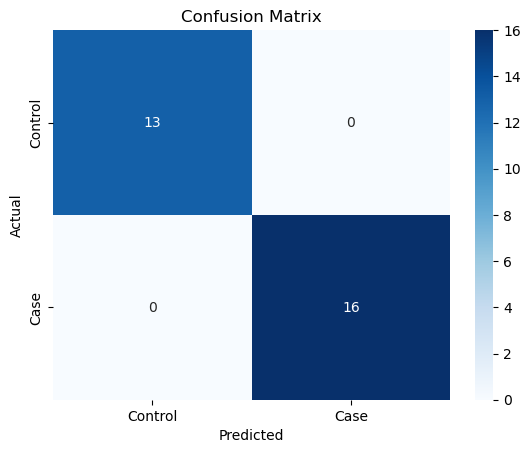

In [264]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Case'], yticklabels=['Control', 'Case'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [265]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Accuracy: 1.0
F1 Score: 1.0
Specificity: 1.0
Sensitivity: 1.0


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization) - L1 Feature Selection

In [266]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [267]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [268]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [269]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_final.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_final, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [270]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 0.8811188811188811, F1 Score: 0.8957055214723927, Sensitivity: 1.0, Specificity: 0.7571428571428571          
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivit

In [271]:
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best Accuracy: 1.0
Best F1 Score: 1.0
Best Specificity: 1.0
Best Sensitivity: 1.0


In [272]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_selected.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_421"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2620 (Dense)                   │ (None, 96)                  │           9,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1434 (Dropout)               │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2621 (Dense)                   │ (None, 32)                  │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1435 (Dropout)               │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2622 (Dense)                   │ (None, 96)                  │           3,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2623 (Dense)                   │ (None, 100)                 │           9,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2624 (Dense)                   │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,769 (100.66 KB)

 Trainable params: 25,769 (100.66 KB)

 Non-trainable params: 0 (0.00 B)

In [273]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 96
Neurons in second layer: 32
Dropout rate: 0.5386661910221705
Learning rate: 0.004955875072875804
Number of epochs: 100
Batch size: 96


## Bidirectional LSTM with Bayesian Optimization - L1 Feature Selection

In [274]:
def create_rnn_model(input_shape, units=64, bidirectional=False, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=False)))
    else:
        model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [275]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [276]:
space = {
    'units': scope.int(hp.quniform('units', 16, 64, 16)),  # Reduced range for faster evaluation
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),  # Reduced range
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),  # Adjusted range
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),  # Reduced number of epochs
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),  # Reduced range
    'bidirectional': hp.choice('bidirectional', [True, False])
}

In [277]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)  
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = KerasClassifier(
            model=create_rnn_model,
            input_shape=(X_final.shape[1], 1),
            units=params['units'],
            bidirectional=params['bidirectional'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
        specificity = tn / (tn + fp)  # True Negative Rate

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [278]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials
            trials=trials)

Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Sc

In [279]:
best_params = {
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size']),
    'bidirectional': best['bidirectional']
}

print("Best Hyperparameters:", best_params)

# Build and summarize the best model
best_model = create_rnn_model(
    input_shape=(X_final.shape[1], 1),
    units=best_params['units'],
    bidirectional=best_params['bidirectional'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


Best Hyperparameters: {'units': 64, 'dropout_rate': 0.1631265092403118, 'learning_rate': 0.0008765545800212953, 'epochs': 40, 'batch_size': 48, 'bidirectional': 1}


In [280]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step

Test Performance:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## GRU with Bayesian Optimization - L1 Feature Selection

In [281]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [282]:
def create_gru_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [283]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [284]:
space = {
    'units': scope.int(hp.quniform('units', 64, 128, 64)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 20, 30, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [285]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        model = KerasClassifier(
            model=create_gru_model,
            input_shape=(X_final.shape[1], 1),
            units=params['units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        y_val_pred = model.predict(X_val)
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)
    
    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")
    
    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [286]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
Iteration Results - Accuracy: 1.0, F1 Sc

In [287]:
best_params = space_eval(space, best)  
print("Best Parameters:", best_params)  

Best Parameters: {'batch_size': 64, 'dropout_rate': 0.329935194325242, 'epochs': 30, 'learning_rate': 0.00020440492030845758, 'units': 64}


In [288]:
best_model = create_gru_model(
    input_shape=(X_final.shape[1], 1),
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [289]:
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [290]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [291]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step

Test Performance:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## CNN with Bayesian Optimization - L1 Feature Selection

In [292]:
X_selected = X_final.reshape(X_final.shape[0], X_final.shape[1], 1)  # Add a channel dimension

In [293]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [294]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [295]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [296]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [297]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                

Iteration Results - Accuracy: 0.8421052631578947, F1 Score: 0.896551724137931, Sensitivity: 1.0, Specificity: 0.6666666666666666
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                

1/2 ━━

In [298]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 16, 'dropout_rate': 0.4349232224978236, 'epochs': 30, 'filters': 96, 'kernel_size': 5, 'learning_rate': 0.00022885738106947785}


In [299]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [300]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [301]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [302]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## ResNet - L1 Feature Selection

In [303]:
X_selected = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [304]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [305]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same', strides=1)(x)
    x = BatchNormalization()(x)
    
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv1D(filters, kernel_size, padding='same', strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [306]:
def create_resnet_model(input_shape, filters=64, num_blocks=6, kernel_size=3, dropout_rate=0.5, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters, kernel_size=kernel_size, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    for _ in range(num_blocks):
        x = residual_block(x, filters, kernel_size=kernel_size)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [307]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'num_blocks': scope.int(hp.quniform('num_blocks', 4, 10, 2)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 3, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),
    'epochs': scope.int(hp.quniform('epochs', 20, 50, 10))
}

In [308]:
def objective(params):
    print(f"Trying params: {params}")
    filters = params['filters']
    num_blocks = params['num_blocks']
    kernel_size = params['kernel_size']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    # Create the ResNet model
    model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                filters=filters,
                                num_blocks=num_blocks,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                learning_rate=learning_rate)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Filters: {filters}, Blocks: {num_blocks}, Kernel Size: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch Size: {batch_size}, Epochs: {epochs}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [309]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Adjust the number of evaluations
            trials=trials)

Trying params: {'batch_size': 32, 'dropout_rate': 0.35880073769406673, 'epochs': 20, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.007245039504060639, 'num_blocks': 6}
Iteration - Loss: 6.547352313995361, Filters: 64, Blocks: 6, Kernel Size: 5, Dropout: 0.35880073769406673, LR: 0.007245039504060639, Batch Size: 32, Epochs: 20
Trying params: {'batch_size': 48, 'dropout_rate': 0.2058811588997866, 'epochs': 30, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.0009652196036188366, 'num_blocks': 8}
Iteration - Loss: 33.04375076293945, Filters: 64, Blocks: 8, Kernel Size: 5, Dropout: 0.2058811588997866, LR: 0.0009652196036188366, Batch Size: 48, Epochs: 30
Trying params: {'batch_size': 48, 'dropout_rate': 0.354750167251099, 'epochs': 40, 'filters': 32, 'kernel_size': 5, 'learning_rate': 0.006603455262505873, 'num_blocks': 6}
Iteration - Loss: 641.5906372070312, Filters: 32, Blocks: 6, Kernel Size: 5, Dropout: 0.354750167251099, LR: 0.006603455262505873, Batch Size: 48, Epochs: 40
Tr

In [310]:
best_params = space_eval(space, best)
print(f"Best parameters: {best_params}")

Best parameters: {'batch_size': 16, 'dropout_rate': 0.2170412918524249, 'epochs': 40, 'filters': 96, 'kernel_size': 3, 'learning_rate': 0.0006030820962932524, 'num_blocks': 10}


In [311]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                 filters=best_params['filters'],
                                 num_blocks=best_params['num_blocks'],
                                 kernel_size=best_params['kernel_size'],
                                 dropout_rate=best_params['dropout_rate'],
                                 learning_rate=best_params['learning_rate'])

In [312]:
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 566ms/step - accuracy: 0.7919 - loss: 0.7597 - val_accuracy: 0.2500 - val_loss: 74.1123
Epoch 2/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.9962 - loss: 0.0079 - val_accuracy: 0.2500 - val_loss: 63.3108
Epoch 3/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 559ms/step - accuracy: 1.0000 - loss: 1.4858e-04 - val_accuracy: 0.2500 - val_loss: 38.6501
Epoch 4/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 556ms/step - accuracy: 0.9975 - loss: 0.0027 - val_accuracy: 0.2500 - val_loss: 30.5817
Epoch 5/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 1.0000 - loss: 4.7079e-05 - val_accuracy: 0.2500 - val_loss: 41.9714
Epoch 6/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 562ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.2500 - val_loss: 41.8708
Epoch 7/40
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 611ms/step - accuracy: 1.0000 - loss: 6.2477e-05 - val_accuracy: 0.2500 - val_loss: 34.1777


In [313]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


In [314]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.5517241379310345
F1 Score: 0.7111111111111111
Sensitivity: 1.0
Specificity: 0.0


## FNN with Bayesian Optimization - L1 Feature Selection

In [315]:
X_selected = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [316]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [317]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [318]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [319]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [320]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 1.613064188329016e-32, Params: {'batch_size': 80, 'dropout_rate': 0.15247211362526084, 'epochs': 120, 'learning_rate': 5.571821808125691e-05, 'num_layers': 3, 'units': 96}
Iteration - Loss: 1.7648033574498291e-37, Params: {'batch_size': 96, 'dropout_rate': 0.20680995729986115, 'epochs': 80, 'learning_rate': 0.0019300771393917131, 'num_layers': 5, 'units': 96}
Iteration - Loss: 0.0, Params: {'batch_size': 32, 'dropout_rate': 0.25258970236659845, 'epochs': 60, 'learning_rate': 0.0005242774342541668, 'num_layers': 4, 'units': 160}
Iteration - Loss: 0.0, Params: {'batch_size': 64, 'dropout_rate': 0.1581991977702674, 'epochs': 120, 'learning_rate': 0.0006851893191717316, 'num_layers': 2, 'units': 96}
Iteration - Loss: 2.1561097609943608e-35, Params: {'batch_size': 112, 'dropout_rate': 0.16717998194003225, 'epochs': 100, 'learning_rate': 0.00023934561716768086, 'num_layers': 2, 'units': 96}
Iteration - Loss: 9.288795298448087e-33, Params: {'batch_size': 32, 'dropout_rate': 

In [321]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.25258970236659845, 'epochs': 60, 'learning_rate': 0.0005242774342541668, 'num_layers': 4, 'units': 160}


In [322]:
best_model = create_fnn_model(input_dim=X_train.shape[1],
                              num_layers=best_params['num_layers'],
                              units=best_params['units'],
                              dropout_rate=best_params['dropout_rate'],
                              learning_rate=best_params['learning_rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                         validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5520 - loss: 18.3695 - val_accuracy: 1.0000 - val_loss: 4.0949e-14
Epoch 2/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.8719 - loss: 2.4831 - val_accuracy: 1.0000 - val_loss: 4.9269e-27
Epoch 3/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.9841 - loss: 0.3528 - val_accuracy: 1.0000 - val_loss: 1.6568e-33
Epoch 4/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9755 - loss: 0.4696 - val_accuracy: 1.0000 - val_loss: 5.2090e-35
Epoch 5/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.9695 - loss: 0.6721 - val_accuracy: 1.0000 - val_loss: 1.3391e-35
Epoch 6/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 2.4165e-11 - val_accuracy: 1.0000 - val_loss: 7.3877e-36
Epoch 7/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 1.0000 - loss: 8.1271e-05 - val_accuracy: 1.0000 - val_loss: 4.4043e-36
Epoch 8/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9869 - loss: 0.1485 - val

In [323]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

Test Performance:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## BERT Transformer - L1 Feature Selection

In [324]:
sequences = [' '.join(map(str, row)) for row in X_final]
labels = case_control_info.map({'Control': 0, 'Case': 1}).values

In [325]:
class SNPDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [326]:
def objective(trial):
    # Suggest hyperparameters
    num_train_epochs = trial.suggest_int('num_train_epochs', 2, 3)  # Reduced number of epochs for faster trials
    batch_size = trial.suggest_categorical('batch_size', [16, 32])  # Higher batch sizes might not fit in memory
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    max_length = trial.suggest_int('max_length', 128, 256)  # Reduced sequence length

    # Load DistilBERT tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

    # Split the data
    train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

    # Create PyTorch Datasets
    train_dataset = SNPDataset(train_encodings, train_labels)
    val_dataset = SNPDataset(val_encodings, val_labels)

    # Define TrainingArguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        save_strategy="epoch",
        save_total_limit=1  # Keep only the last checkpoint
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate(eval_dataset=val_dataset)

    # Return the evaluation metric to be minimized
    return eval_result['eval_loss']

In [327]:
study = optuna.create_study(direction='minimize')

[I 2024-07-12 14:53:42,584] A new study created in memory with name: no-name-a3160ed7-7002-4dd8-8525-c11aff9c6e6a


In [328]:
study.optimize(objective, n_trials=5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.716626
2,No log,0.698509
3,0.699600,0.667108


[I 2024-07-12 14:55:06,878] Trial 0 finished with value: 0.6671084761619568 and parameters: {'num_train_epochs': 3, 'batch_size': 32, 'learning_rate': 4.856499822311121e-05, 'max_length': 134}. Best is trial 0 with value: 0.6671084761619568.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.686299
2,0.695200,0.663805


[I 2024-07-12 14:56:05,219] Trial 1 finished with value: 0.6638049483299255 and parameters: {'num_train_epochs': 2, 'batch_size': 16, 'learning_rate': 2.0158319808871435e-05, 'max_length': 139}. Best is trial 1 with value: 0.6638049483299255.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.683296
2,0.690200,0.668998
3,0.671200,0.633130


[I 2024-07-12 14:57:53,914] Trial 2 finished with value: 0.6331299543380737 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 1.7072039513452154e-05, 'max_length': 181}. Best is trial 2 with value: 0.6331299543380737.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.687011
2,0.698700,0.660533
3,0.665900,0.578080


[I 2024-07-12 15:00:32,439] Trial 3 finished with value: 0.5780798196792603 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 3.276086624838993e-05, 'max_length': 253}. Best is trial 3 with value: 0.5780798196792603.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.690209
2,0.700200,0.674913


[I 2024-07-12 15:01:41,228] Trial 4 finished with value: 0.6749125719070435 and parameters: {'num_train_epochs': 2, 'batch_size': 16, 'learning_rate': 1.903431740919383e-05, 'max_length': 168}. Best is trial 3 with value: 0.5780798196792603.


In [329]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 3.276086624838993e-05, 'max_length': 253}


In [330]:
best_params = study.best_params

In [331]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [332]:
train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
train_dataset = SNPDataset(train_encodings, train_labels)
val_dataset = SNPDataset(val_encodings, val_labels)

In [333]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate']
)

In [334]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


In [335]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.891245
2,0.828300,0.787732
3,0.812300,0.660262


TrainOutput(global_step=24, training_loss=0.8077994783719381, metrics={'train_runtime': 668.8895, 'train_samples_per_second': 0.511, 'train_steps_per_second': 0.036, 'total_flos': 89983980933120.0, 'train_loss': 0.8077994783719381, 'epoch': 3.0})

In [336]:
predictions, labels, _ = trainer.predict(val_dataset)
preds = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_labels, preds)
f1 = f1_score(val_labels, preds)
conf_matrix = confusion_matrix(val_labels, preds)

# Compute specificity and sensitivity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.4482758620689655
F1 Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


## Sparse Autoencoder - L1 Feature Selection

In [337]:
X_train, X_val, y_train, y_val= train_test_split(X_final, y, test_size=0.2, random_state=42)

In [338]:
def create_sparse_autoencoder(input_dim, num_units, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(num_units, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer))(input_layer)
    encoder = Dropout(dropout_rate)(encoder)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    return autoencoder

In [339]:
def objective(trial):
    # Hyperparameters to tune
    num_units = trial.suggest_int('num_units', 64, 256)  # Reduced upper bound
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)  # Lower upper bound
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)  # Reduced upper bound
    activity_regularizer = trial.suggest_float('activity_regularizer', 1e-7, 1e-4, log=True)  # Reduced range
    batch_size = trial.suggest_int('batch_size', 16, 64)  # Reduced upper bound

    # Create the model
    model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=num_units, dropout_rate=dropout_rate, activity_regularizer=activity_regularizer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

    # Set early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, X_train, epochs=50, batch_size=batch_size, validation_data=(X_val, X_val), callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')], verbose=0)

    # Return the best validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

In [340]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-07-12 15:13:12,457] A new study created in memory with name: no-name-c59c9e0c-68ba-454e-a61c-6e85a68fbd58
[I 2024-07-12 15:13:18,286] Trial 0 finished with value: 11543.31640625 and parameters: {'num_units': 205, 'learning_rate': 0.000551975535007481, 'dropout_rate': 0.27900912161667457, 'activity_regularizer': 2.45449202731343e-05, 'batch_size': 55}. Best is trial 0 with value: 11543.31640625.
[I 2024-07-12 15:13:21,826] Trial 1 finished with value: 11567.650390625 and parameters: {'num_units': 173, 'learning_rate': 0.0007725727867398789, 'dropout_rate': 0.023116545765117822, 'activity_regularizer': 6.932520821445915e-07, 'batch_size': 36}. Best is trial 0 with value: 11543.31640625.
[I 2024-07-12 15:13:29,501] Trial 2 finished with value: 11582.5146484375 and parameters: {'num_units': 115, 'learning_rate': 3.258312157248798e-05, 'dropout_rate': 0.2586509403555989, 'activity_regularizer': 1.2825486808245458e-05, 'batch_size': 26}. Best is trial 0 with value: 11543.31640625.
[I

In [341]:
best_params = study.best_params
print("Best Hyperparameters: ", best_params)

Best Hyperparameters:  {'num_units': 238, 'learning_rate': 0.0009728335112425338, 'dropout_rate': 0.27433758741587366, 'activity_regularizer': 1.5421010823501744e-06, 'batch_size': 59}


In [342]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [343]:
best_model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=best_params['num_units'], dropout_rate=best_params['dropout_rate'], activity_regularizer=best_params['activity_regularizer'])
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss=MeanSquaredError())
best_model.fit(X_train, X_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_val, X_val), callbacks=[early_stopping], verbose=1)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - loss: 10889.9111 - val_loss: 11592.5410
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 10963.3418 - val_loss: 11583.9004
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 11043.0059 - val_loss: 11575.6699
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 11023.9805 - val_loss: 11565.1543
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 10664.7637 - val_loss: 11562.7129
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 10547.3740 - val_loss: 11560.9561
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 11005.1738 - val_loss: 11557.0977
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 11163.2852 - val_loss: 11555.2246
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 10937.8965 - val_loss: 11552.1953
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 10982.7314 - val_loss: 11550.9619
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 10907.1729 - val_loss: 11549.1

In [344]:
val_loss = best_model.evaluate(X_val, X_val)
print("Validation Loss: ", val_loss)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 11543.1982
Validation Loss:  11543.1982421875


In [345]:
reconstructions = best_model.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [346]:
threshold = np.percentile(reconstruction_errors, 95)
y_pred = (reconstruction_errors > threshold).astype(int)

In [347]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

In [348]:
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.5172413793103449
F1 Score: 0.2222222222222222
Sensitivity: 0.125
Specificity: 1.0


## Stacked Autoencoder & LSTM Model - L1 Feature Selection

In [349]:
X_final = X_final.astype('float32')
y = y.astype('float32')

In [350]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [351]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [352]:
def create_bilstm_model(input_shape, lstm_units, dropout_rate, output_dim):
    inputs = Input(shape=(input_shape[1], input_shape[2]), dtype='float32')
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, dtype='float32'))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, dtype='float32'))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_dim, activation='sigmoid', dtype='float32')(x)
    model = Model(inputs, outputs)
    return model

In [353]:
def create_stacked_model(X_train, X_val, autoencoder_params, lstm_params):
    input_dim = X_train.shape[1]
    
    # Autoencoder part
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=input_dim,
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=autoencoder_params['batch_size'], validation_data=(X_val, X_val), verbose=0)

    # Encoder output
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')
    
    # Prepare for LSTM
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # BiLSTM part
    lstm_model = create_bilstm_model(input_shape=X_encoded_train.shape, lstm_units=lstm_params['lstm_units'], dropout_rate=lstm_params['dropout_rate'], output_dim=1)
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    return autoencoder, lstm_model, X_encoded_train, X_encoded_val

In [354]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        autoencoder_params = {
            'encoding_dim': int(params['encoding_dim']),
            'hidden_layers': [int(params['autoencoder_units'])],
            'dropout_rate': params['ae_dropout_rate'],
            'activity_regularizer': params['ae_activity_reg'],
            'learning_rate': params['ae_learning_rate'],
            'batch_size': int(params['ae_batch_size'])
        }
        
        lstm_params = {
            'lstm_units': int(params['lstm_units']),
            'dropout_rate': params['lstm_dropout_rate'],
            'learning_rate': params['lstm_learning_rate'],
            'batch_size': int(params['lstm_batch_size'])
        }

        autoencoder, lstm_model, X_encoded_train, X_encoded_val = create_stacked_model(X_train, X_val, autoencoder_params, lstm_params)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        lstm_model.fit(X_encoded_train, y_train, epochs=50, batch_size=lstm_params['batch_size'], validation_data=(X_encoded_val, y_val), callbacks=[early_stopping], verbose=0)
        
        y_val_pred = lstm_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [355]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'lstm_units': hp.quniform('lstm_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'lstm_dropout_rate': hp.uniform('lstm_dropout_rate', 0.1, 0.5),
    'lstm_learning_rate': hp.loguniform('lstm_learning_rate', np.log(1e-5), np.log(1e-2)),
    'lstm_batch_size': hp.quniform('lstm_batch_size', 16, 64, 1)
}

In [356]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step                                              
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step                                              

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step             

In [357]:
print("Best parameters found: ", best)

Best parameters found:  {'ae_activity_reg': 2.1351056862712892e-05, 'ae_batch_size': 49.0, 'ae_dropout_rate': 0.13247701176339421, 'ae_learning_rate': 0.0028864751586432148, 'autoencoder_units': 278.0, 'encoding_dim': 46.0, 'lstm_batch_size': 53.0, 'lstm_dropout_rate': 0.374107159142425, 'lstm_learning_rate': 8.96166927825026e-05, 'lstm_units': 132.0}


In [358]:
best_params = {
    'encoding_dim': best['encoding_dim'],
    'autoencoder_units': best['autoencoder_units'],
    'lstm_units': best['lstm_units'],
    'ae_dropout_rate': best['ae_dropout_rate'],
    'ae_activity_reg': best['ae_activity_reg'],
    'ae_learning_rate': best['ae_learning_rate'],
    'ae_batch_size': best['ae_batch_size'],
    'lstm_dropout_rate': best['lstm_dropout_rate'],
    'lstm_learning_rate': best['lstm_learning_rate'],
    'lstm_batch_size': best['lstm_batch_size']
}

In [359]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [360]:
def train_final_model(X_train, y_train, X_val, y_val, best_params):
    # Extracting autoencoder parameters from the best params
    autoencoder_params = {
        'encoding_dim': int(best_params['encoding_dim']),
        'hidden_layers': [int(best_params['autoencoder_units'])],
        'dropout_rate': best_params['ae_dropout_rate'],
        'activity_regularizer': best_params['ae_activity_reg'],
        'learning_rate': best_params['ae_learning_rate'],
        'batch_size': int(best_params['ae_batch_size'])
    }

    # Extracting BiLSTM parameters from the best params
    lstm_params = {
        'lstm_units': int(best_params['lstm_units']),
        'dropout_rate': best_params['lstm_dropout_rate'],
        'learning_rate': best_params['lstm_learning_rate'],
        'batch_size': int(best_params['lstm_batch_size'])
    }

    # Create the stacked model
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=X_train.shape[1],
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )

    # Compile and train the autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=autoencoder_params['batch_size'],
        validation_data=(X_val, X_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    # Encode the training and validation data
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')

    # Reshape the encoded data for LSTM input
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # Create and compile the BiLSTM model
    lstm_model = create_bilstm_model(
        input_shape=X_encoded_train.shape,
        lstm_units=lstm_params['lstm_units'],
        dropout_rate=lstm_params['dropout_rate'],
        output_dim=1  # Assuming binary classification
    )
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the BiLSTM model
    lstm_model.fit(
        X_encoded_train, y_train,
        epochs=50,
        batch_size=lstm_params['batch_size'],
        validation_data=(X_encoded_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    return lstm_model, X_encoded_val

In [361]:
lstm_model, X_encoded_val = train_final_model(X_train_val, y_train_val, X_test, y_test, best_params)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - loss: 10871.0234 - val_loss: 11556.5850
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 10826.1045 - val_loss: 11551.6152
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 10717.3857 - val_loss: 11550.0537
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 10941.1855 - val_loss: 11550.1064
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 11064.4619 - val_loss: 11549.9893
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 10928.9307 - val_loss: 11549.7988
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 10733.8643 - val_loss: 11549.5566
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 11191.6914 - val_loss: 11549.2979
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 10655.6885 - val_loss: 11549.0176
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 11159.5439 - val_loss: 11548.7529
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 10884.5391 - val_loss: 11548.29

In [362]:
y_val_pred = lstm_model.predict(X_encoded_val).flatten()
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_val_pred_binary)
f1 = f1_score(y_test, y_val_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_val_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## Stacked Autoencoder & FNN Model - L1 Feature Selection

In [363]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [364]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [365]:
def ensure_float32(data):
    return data.astype(np.float32)

In [366]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [367]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [368]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [369]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [370]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step            

In [371]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [372]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [373]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Final Model - Accuracy: 1.0
Final Model - F1 Score: 1.0
Final Model - Sensitivity: 1.0
Final Model - Specificity: 1.0


## FNN with Bayesian Optimization - 1500 SNPs

In [374]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [375]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [376]:
amgm_values = calculate_amgm(X)

In [377]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [378]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [379]:
X_selected = X[selected_indices, :].T

In [380]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [381]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [382]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [383]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [384]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [385]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [386]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.00021030736388638616, Params: {'batch_size': 96, 'dropout_rate': 0.14074252584499358, 'epochs': 130, 'learning_rate': 0.00021190267156108526, 'num_layers': 2, 'units': 64}
Iteration - Loss: 1.2997003977943677e-05, Params: {'batch_size': 32, 'dropout_rate': 0.2641816788066842, 'epochs': 120, 'learning_rate': 8.31210369183118e-05, 'num_layers': 5, 'units': 96}
Iteration - Loss: 0.0003830895002465695, Params: {'batch_size': 16, 'dropout_rate': 0.35595824048690916, 'epochs': 50, 'learning_rate': 7.703847018257114e-05, 'num_layers': 4, 'units': 96}
Iteration - Loss: 6.812022184021771e-05, Params: {'batch_size': 48, 'dropout_rate': 0.30740585809366294, 'epochs': 100, 'learning_rate': 7.081088177616459e-05, 'num_layers': 6, 'units': 256}
Iteration - Loss: 4.249952015691744e-29, Params: {'batch_size': 32, 'dropout_rate': 0.47538144138303073, 'epochs': 70, 'learning_rate': 0.0034339752812273657, 'num_layers': 5, 'units': 128}
Iteration - Loss: 4.805560825252655e-38, Params: 

In [387]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.32487358097082275, 'epochs': 90, 'learning_rate': 0.005127009586457209, 'num_layers': 4, 'units': 256}


In [388]:
def evaluate_model_with_kfold(X_selected, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_selected):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_fnn_model(input_dim=X_train.shape[1],
          num_layers=best_params['num_layers'],
          units=best_params['units'],
          dropout_rate=best_params['dropout_rate'],
          learning_rate=best_params['learning_rate'])
        
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [389]:
evaluate_model_with_kfold(X_train, y_train, best_params, k=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

K-Fold Cross-Validation Results:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization) - 1500 SNPs

In [390]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [391]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [392]:
amgm_values = calculate_amgm(X)

In [393]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [394]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [ 22804  57998 106985 132047 110532 112987  51373  15126  81955 129319]
Top AMGM values: [1.04099581 1.04099584 1.04099812 1.04100497 1.04100979 1.04101025
 1.04101192 1.04101339 1.04101339 1.04101594]


In [395]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [396]:
X_selected = X[selected_indices, :].T

In [397]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [398]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values  

In [399]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [400]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [401]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [402]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivit

In [403]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_selected.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_771"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4860 (Dense)                   │ (None, 192)                 │         288,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2773 (Dropout)               │ (None, 192)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4861 (Dense)                   │ (None, 112)                 │          21,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2774 (Dropout)               │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4862 (Dense)                   │ (None, 192)                 │          21,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4863 (Dense)                   │ (None, 1500)                │         289,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4864 (Dense)                   │ (None, 1)                   │           1,501 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 622,505 (2.37 MB)

 Trainable params: 622,505 (2.37 MB)

 Non-trainable params: 0 (0.00 B)

In [404]:
def evaluate_model_with_kfold(X_selected, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_selected):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_deep_autoencoder(
            input_dim=X_selected.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [405]:
evaluate_model_with_kfold(X_selected, y, best_params, k=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

K-Fold Cross-Validation Results:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## CNN with Bayesian Optimization - 1500 SNPs

In [406]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [407]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [408]:
amgm_values = calculate_amgm(X)

In [409]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [410]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [411]:
X_selected = X[selected_indices, :].T

In [412]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [413]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [414]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [415]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [416]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [417]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [418]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step                                                

Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
1/1 ━━━━━━━━━━━

In [419]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.37605187407078466, 'epochs': 30, 'filters': 64, 'kernel_size': 5, 'learning_rate': 0.0022858647507914406}


In [420]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [421]:
def evaluate_model_with_kfold(X_selected, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_selected):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_cnn_model(
            input_shape=(X_train.shape[1], 1),
            filters=int(best_params['filters']),
            kernel_size=int(best_params['kernel_size']),
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [422]:
evaluate_model_with_kfold(X_selected, y, best_params, k=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

K-Fold Cross-Validation Results:
Accuracy: 0.8519704433497537
F1 Score: 0.8995348837209303
Sensitivity: 1.0
Specificity: 0.676923076923077


## Stacked Autoencoder & FNN Model

In [423]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [424]:
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
y = case_control_info.map({'Control': 0, 'Case': 1}).values.astype(np.float32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

In [425]:
amgm_values = calculate_amgm(X)

In [426]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [427]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [428]:
X_selected = X[selected_indices, :].T

In [429]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [430]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [431]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [432]:
def ensure_float32(data):
    return data.astype(np.float32)

In [433]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [434]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [435]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [436]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [437]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [438]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step            

In [439]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [440]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [441]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Final Model - Accuracy: 1.0
Final Model - F1 Score: 1.0
Final Model - Sensitivity: 1.0
Final Model - Specificity: 1.0


## Deep Autoencoder - ReliefF

In [442]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [443]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.T.astype(np.float32)
y = case_control_info.map({'Control': 0, 'Case': 1}).values.astype(np.int32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

In [444]:
def select_features_relieff(X, y, num_features):
    relief = ReliefF(n_neighbors=100, n_features_to_select=num_features, discrete_threshold=10)
    relief.fit(X, y)
    return relief.top_features_[:num_features]

In [445]:
relieff_indices = select_features_relieff(X_scaled, y, 1000)
X_final = X_scaled[:, relieff_indices]

In [446]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [447]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [448]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_final.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_final, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [449]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivit

In [450]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_final.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_983"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6232 (Dense)                   │ (None, 96)                  │          96,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3513 (Dropout)               │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6233 (Dense)                   │ (None, 64)                  │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3514 (Dropout)               │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6234 (Dense)                   │ (None, 96)                  │           6,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6235 (Dense)                   │ (None, 1000)                │          97,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6236 (Dense)                   │ (None, 1)                   │           1,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,545 (806.82 KB)

 Trainable params: 206,545 (806.82 KB)

 Non-trainable params: 0 (0.00 B)

In [451]:
def evaluate_model_with_kfold(X_final, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_final):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_deep_autoencoder(
            input_dim=X_final.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [452]:
evaluate_model_with_kfold(X_final, y, best_params, k=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

K-Fold Cross-Validation Results:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## FNN with Relieff FS

In [453]:
X_final = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [454]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [455]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [456]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 8, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 32, 256, 32))
}

In [457]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [458]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 1.6588442366487676e-29, Params: {'batch_size': 64, 'dropout_rate': 0.6764772343088655, 'epochs': 100, 'learning_rate': 0.0018453516498167786, 'num_layers': 3, 'units': 160}
Iteration - Loss: 0.00029653043020516634, Params: {'batch_size': 32, 'dropout_rate': 0.3259424851677639, 'epochs': 120, 'learning_rate': 2.5279373297611772e-05, 'num_layers': 5, 'units': 256}
Iteration - Loss: 0.0002052961353911087, Params: {'batch_size': 256, 'dropout_rate': 0.5159414091045125, 'epochs': 70, 'learning_rate': 0.0002225010770955179, 'num_layers': 3, 'units': 96}
Iteration - Loss: 0.41933247447013855, Params: {'batch_size': 128, 'dropout_rate': 0.1762746077605591, 'epochs': 80, 'learning_rate': 1.0779516399260584e-05, 'num_layers': 3, 'units': 160}
Iteration - Loss: 0.04962626099586487, Params: {'batch_size': 256, 'dropout_rate': 0.15016664475731192, 'epochs': 70, 'learning_rate': 1.2772472253169798e-05, 'num_layers': 2, 'units': 224}
Iteration - Loss: 0.633948802947998, Params: {'ba

In [459]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 160, 'dropout_rate': 0.4280077342108609, 'epochs': 120, 'learning_rate': 0.0024780415116314562, 'num_layers': 4, 'units': 256}


In [460]:
def evaluate_model_with_kfold(X_final, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_final):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_fnn_model(input_dim=X_train.shape[1],
          num_layers=best_params['num_layers'],
          units=best_params['units'],
          dropout_rate=best_params['dropout_rate'],
          learning_rate=best_params['learning_rate'])
        
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [461]:
evaluate_model_with_kfold(X_train, y_train, best_params, k=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

K-Fold Cross-Validation Results:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## CNN with ReliefF

In [462]:
X_selected = X_final.reshape(X_final.shape[0], X_final.shape[1], 1)  # Add a channel dimension

In [463]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [464]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [465]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [466]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [467]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step                                                

Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step                                                
2/2 ━━━━━━━━━━━━

In [468]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.3785322062247236, 'epochs': 40, 'filters': 96, 'kernel_size': 3, 'learning_rate': 0.0009816851509903747}


In [469]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [470]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [471]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


In [472]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## Deep Autoencoder & FNN with ReliefF

In [473]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [474]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [475]:
def ensure_float32(data):
    return data.astype(np.float32)

In [476]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [477]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [478]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [479]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [480]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [481]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step            

In [482]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [483]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [484]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Final Model - Accuracy: 1.0
Final Model - F1 Score: 1.0
Final Model - Sensitivity: 1.0
Final Model - Specificity: 1.0


## Deep Autoencoder with Hybrid FS

In [485]:
input_file_path = 'C:/Research_Summer/FinalizedLeukemiaData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_15068\386548609.py:2: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=0, index_col=0)


In [486]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.T.astype(np.float32)
y = case_control_info.map({'Control': 0, 'Case': 1}).values.astype(np.int32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

In [487]:
def select_features_cmim(X, y, num_features):
    mi_scores = mutual_info_classif(X, y)
    top_indices = np.argsort(mi_scores)[-num_features:]
    return top_indices

In [488]:
def select_features_svm_rfe(X, y, num_features):
    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=num_features, step=1)
    rfe.fit(X, y)
    return np.where(rfe.support_)[0]

In [489]:
num_features_cmim = 5000  # Number of features to keep after CMIM
cmim_indices = select_features_cmim(X_scaled, y, num_features_cmim)
X_cmim = X_scaled[:, cmim_indices]

# Second step: Apply SVM-RFE on the reduced feature space from CMIM
num_features_final = 1000  # Number of final features to select
svm_rfe_indices = select_features_svm_rfe(X_cmim, y, num_features_final)
X_final = X_cmim[:, svm_rfe_indices]

print(f"Shape of final selected features: {X_final.shape}")

Shape of final selected features: (143, 1000)


In [490]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [491]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [492]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_final.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_final, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [493]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivit

In [494]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_selected.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_1185"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7719 (Dense)                   │ (None, 160)                 │         160,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4288 (Dropout)               │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7720 (Dense)                   │ (None, 112)                 │          18,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4289 (Dropout)               │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7721 (Dense)                   │ (None, 160)                 │          18,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7722 (Dense)                   │ (None, 1000)                │         161,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7723 (Dense)                   │ (None, 1)                   │           1,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 358,273 (1.37 MB)

 Trainable params: 358,273 (1.37 MB)

 Non-trainable params: 0 (0.00 B)

In [495]:
def evaluate_model_with_kfold(X_final, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_final):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_deep_autoencoder(
            input_dim=X_final.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [496]:
evaluate_model_with_kfold(X_final, y, best_params, k=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

K-Fold Cross-Validation Results:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## FNN with Hybrid FS

In [497]:
X_final = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [498]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [499]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [500]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 8, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 32, 256, 32))
}

In [501]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [502]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 9.92361053536293e-18, Params: {'batch_size': 160, 'dropout_rate': 0.24210932670115573, 'epochs': 60, 'learning_rate': 0.0011493540457024915, 'num_layers': 7, 'units': 64}
Iteration - Loss: 0.6807534098625183, Params: {'batch_size': 256, 'dropout_rate': 0.5371504353166775, 'epochs': 130, 'learning_rate': 4.307197033871411e-05, 'num_layers': 7, 'units': 192}
Iteration - Loss: 5.826075177850498e-10, Params: {'batch_size': 192, 'dropout_rate': 0.5338400118649643, 'epochs': 150, 'learning_rate': 0.0006998041378416233, 'num_layers': 4, 'units': 96}
Iteration - Loss: 0.00023176737886387855, Params: {'batch_size': 224, 'dropout_rate': 0.238342722420981, 'epochs': 140, 'learning_rate': 4.9196361428305885e-05, 'num_layers': 7, 'units': 160}
Iteration - Loss: 0.0, Params: {'batch_size': 96, 'dropout_rate': 0.31195845990052135, 'epochs': 90, 'learning_rate': 0.0019270086703169673, 'num_layers': 7, 'units': 192}
Iteration - Loss: 2.6432948870194704e-34, Params: {'batch_size': 64, 

In [503]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 96, 'dropout_rate': 0.31195845990052135, 'epochs': 90, 'learning_rate': 0.0019270086703169673, 'num_layers': 7, 'units': 192}


In [504]:
def evaluate_model_with_kfold(X_final, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_final):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_fnn_model(input_dim=X_train.shape[1],
          num_layers=best_params['num_layers'],
          units=best_params['units'],
          dropout_rate=best_params['dropout_rate'],
          learning_rate=best_params['learning_rate'])
        
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [505]:
evaluate_model_with_kfold(X_train, y_train, best_params, k=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step

K-Fold Cross-Validation Results:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## CNN with Hybrid FS

In [506]:
X_selected = X_final.reshape(X_final.shape[0], X_final.shape[1], 1)  # Add a channel dimension

In [507]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [508]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [509]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [510]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [511]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step                                               
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step                                                

Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step                                                
2/2 ━━━━━━━━━━━━━━━

In [512]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 48, 'dropout_rate': 0.37961679550827826, 'epochs': 30, 'filters': 96, 'kernel_size': 5, 'learning_rate': 0.0012349087945960823}


In [513]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [514]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [515]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


In [516]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## Deep Autoencoder & FNN with Hybrid FS

In [517]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [518]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [519]:
def ensure_float32(data):
    return data.astype(np.float32)

In [520]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [521]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [522]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [523]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [524]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [525]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step                                                

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step                                                 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                                
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step            

In [526]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [527]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [528]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Final Model - Accuracy: 1.0
Final Model - F1 Score: 1.0
Final Model - Sensitivity: 1.0
Final Model - Specificity: 1.0
